In [1]:
#!/Users/osipova/miniconda3/envs/py13/bin/pip3 install statsmodels

In [80]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
from scipy.stats import mannwhitneyu, ttest_ind
from os.path import join
from glob import glob
import warnings
import logging

## regression; glm
from scipy.stats import linregress
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.special import expit

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings("ignore")

In [2]:
def load_sample_info(file_path):
    df = pd.read_csv(file_path, sep='\t')[[
        'sample_ID', 'rookery-region', 'Year', 'group-Lkadj',
        'Management units - based on DNA', 'Post_dupe_depth_2_all_LKGATK_USE',
        'Exclude-all_GL_ROH_analyses', 'Sequencing_source-type', 'Stage_Class', 'Ok notes'
    ]]
    return df.rename(columns={
        'sample_ID': 'sample',
        'rookery-region': 'rookery',
        'Year': 'year',
        'group-Lkadj': 'group',
        'Management units - based on DNA': 'MU',
        'Post_dupe_depth_2_all_LKGATK_USE': 'depth',
        'Exclude-all_GL_ROH_analyses': 'exclude',
        'Ok notes': 'outlier',
        'Sequencing_source-type': 'batch',
        'Stage_Class': 'stage'
    })

In [3]:
pop_order = ['larger_declining', 'small_stable', 'small_declining', 
             'larger_stable', 'small_recovering']

# 0. Load location and groupings information

In [4]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'dc_222_samples_info.tsv'
file_data = glob(join(dir_path, file_name))[0]
INFO = load_sample_info(file_data)

## 0.1. Define colors

In [5]:
rookery_palette_dict = {
    'Mexico': '#1f77b4',
    'Atl Costa Rica': '#005a32',
    'Indonesia': '#d62728',
    'Pacific Costa Rica': '#7570b3',
    'Papua New Guinea': '#dd3497',
    'Solomon Islands': '#fde0dd',
    'Malaysia': '#2ca02c',
    'South Africa': '#17becf',
    'Ghana': '#ff7f0e',
    'Gabon': '#fdd0a2',
    'French Guiana-Suriname': '#8c564b',
    'Virgin Islands': '#d6eaf8',
    'Florida': '#d9f0a3',
    'na': '#000000',
    'unknown': '#7f7f7f'}

mu_palette_dict = {
    'Eastern Pacific': '#1f77b4',
    'Western Pacific': '#d62728',
    'Northwest Caribbean': '#005a32',
    'Northeast Caribbean': '#6a51a3',
    'Northern Caribbean': '#d9f0a3',
    'South Africa': '#17becf',
    'SE Atlantic/West Africa': '#ff7f0e',
    'South-east Caribbean': '#8c564b',
    'Indo-Western Pacific': '#2ca02c',
    'na': '#000000',
    'unknown': '#7f7f7f'}

batch_palette_dict = {
    'novo_UMass_Illumina_SR': '#1f77b4',
    'novo42_Illumina_SR': '#ff7f0e',
    'LR-getinfofromJH': '#2ca02c',
    'Duffy_Illumina_SR': '#d62728'}

population_palette_dict = {
    'larger_declining': '#d62728',
    'small_stable':'#1f77b4',
    'small_declining': '#005a32',
    'larger_stable': '#ff7f0e',
    'small_recovering': '#6a51a3'}

## Funcition 0: regression

In [6]:
def old_plot_regression(
    ax, df, group_col, x, y, palette=None, annotate_pvalue=True, alpha=1.0):
    """
    Annotate if p < 0.05.
    Returns a dataframe of regression statistics.
    """
    stats_results = []
    unique_groups = df[group_col].unique()
    for group in unique_groups:
        subdf = df[df[group_col] == group]
        slope, intercept, r_value, p_value, std_err = linregress(subdf[x], subdf[y])
        stats_results.append({'group': group, 'slope': slope, 'pvalue': p_value})

        color = palette[group] if palette and group in palette else None
        
        if p_value < 0.05:
            # Plot regression line
            xvals = subdf[x].sort_values()
            y_pred = intercept + slope * xvals
            ax.plot(xvals, y_pred, color=color, 
                    linestyle='-', lw=2, alpha=alpha,
                    label=f"{group} reg")

        if annotate_pvalue and p_value < 0.05:
            maxy = subdf[y].max()
            midx = subdf[x].median()
            ax.text(midx, maxy, f'p = {p_value:.2e}', ha='center', va='bottom', fontsize=12)
    return pd.DataFrame(stats_results)

In [89]:
def plot_regression(
    ax, df, group_col, x, y, palette=None, annotate_pvalue=True, alpha=1.0
):
    """
    Run a GLM/OLS for each group: y ~ x + C(stage).
    Annotate plot with p-values for both year (x) and stage.
    Returns a dataframe of regression statistics.
    """
    stats_results = []
    unique_groups = df[group_col].unique()

    for group in unique_groups:
        subdf = df[df[group_col] == group].copy()

        # Fit model
        if y == 'F_ROH':
            # logit-transform F_ROH
            eps = 1e-6
            tmp = subdf.copy()
            clipped = tmp[y].clip(eps, 1 - eps)
            tmp['_y'] = np.log(clipped / (1 - clipped))  # logit
            model = smf.glm(f"_y ~ {x} + C(stage)", data=tmp).fit()

        else:
            model = smf.glm(f"{y} ~ {x} + C(stage)", data=subdf).fit()

        # Extract coefficients
        slope_year = model.params.get(x, np.nan)
        p_year = model.pvalues.get(x, np.nan)

        stage_terms = {name: p for name, p in model.pvalues.items()
            if "stage" in name and name not in ("Intercept", x)}

        stats_entry = {
            "group": group,
            "slope_year": slope_year,
            "p_year": p_year}
        
        # Add stage p-values
        for term, p in stage_terms.items():
            stats_entry[f"p_{term}"] = p

        stats_results.append(stats_entry)

        # Color choice
        color = palette[group] if palette and group in palette else None

        xvals = np.linspace(subdf[x].min(), subdf[x].max(), 100)
        pred_df = pd.DataFrame({x: xvals})

        if 'stage' in subdf.columns:
            pred_df['stage'] = subdf['stage'].mode()[0]

        pred = model.get_prediction(pred_df)
        pred_mean = pred.predicted_mean
        ci = pred.conf_int()
        lower = ci[:, 0]
        upper = ci[:, 1]

        if y == 'F_ROH':
            # inverse logit: mapped to probability scale
            pred_mean = expit(pred_mean)
            lower = expit(lower)
            upper = expit(upper)

        # Plot regression line
        ax.plot(xvals, pred_mean, color=color, lw=2, alpha=alpha, label=f"{group} reg")

        # Plot CI
        ax.fill_between(xvals, lower, upper, color=color, alpha=0.06)

        # Annotate p-values
        if annotate_pvalue:
            maxy = subdf[y].max()
            miny = subdf[y].min()
            midx = subdf[x].median()

            ax.text(midx, maxy,f"p({x})={p_year:.2e}", ha="center", va="bottom", fontsize=10, color=color)

            y_range = maxy - miny if maxy != miny else 1.0
            y_offset = y_range * 0.08

            for i, (term, p) in enumerate(stage_terms.items()):
                ax.text(
                    midx, maxy - (i + 1) * y_offset,
                    f"p({term})={p:.2e}",
                    ha="center", va="bottom", fontsize=9, color=color)

    return pd.DataFrame(stats_results)

## Function 1: plot all groups

In [7]:
def plot_scatter_grid(
    df, values, x, group_col, hue_palette,
    ncols=3, save_path=None, regress=False):

    nplots = len(values)
    nrows = (nplots + ncols - 1) // ncols
    figsize=(ncols*5, nrows*4)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    axes = axes.flatten()

    for k, v in enumerate(values):
        axi = axes[k]
        
        if 'HIGH' in values:
            dfi = df[(df['impact'] == v) & (df['state'] == 'hom')]
            y = 'number'
        else:
            dfi = df
            y = v
        
        if x == 'year':
            style = 'stage'
            markers_dict = {'adult': 'o', 'hatchling': 'v'}
        else:
            style = None
            markers_dict = None

        dfi = dfi[['sample', x, y, group_col, 'stage']].drop_duplicates()
        
        sns.scatterplot(
            ax=axi, data=dfi, x=x, y=y, hue=group_col,
            alpha=0.8, edgecolor='k', linewidth=0.2, 
            style=style, markers=markers_dict,
            palette=hue_palette)

        axi.set_title(v)
        axi.set_ylabel(f'{y}')
        axi.set_xlabel(x)
        
        if len(values) == 1 or (k % ncols) == (ncols - 1):
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
        else:
            axi.get_legend().set_visible(False)
 
        # Check regression
        if regress:
            stats_df = plot_regression(axi, dfi, group_col, x, y, palette=hue_palette)
            print(v)
            print(stats_df)

    # Hide any unused subplots
    for ax in axes[nplots:]:
        ax.axis('off')

    sns.despine()
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    return fig, axes

## Function 2: plot main groups

In [8]:
def plot_scatter_main(
    df, values, x, group_col, group1, group2,
    hue_palette, pop_palette, ncols=3, save_path=None):
    
    pops = [group1, group2]
    df = df[df['group'].isin(pops)]

    nplots = len(values)
    nrows = (nplots + ncols - 1) // ncols
    figsize=(ncols*5, nrows*4)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    c1 = pop_palette[group1]
    c2 = pop_palette[group2]

    for k, v in enumerate(values):
        ax_main = axes[k]
        
        if 'HIGH' in values:
            dfi = df[(df['impact'] == v) & (df['state'] == 'hom')]
            y = 'number'
        else:
            dfi = df
            y = v
        
        # Subset for statistical test
        data1 = dfi[dfi['group'] == group1][y]
        data2 = dfi[dfi['group'] == group2][y]
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')

        # Regression lines
#         sns.regplot(
#             ax=ax_main, data=dfi[dfi['group'] == group1],
#             x=x, y=v, scatter=False, color=c1, ci=None)
#         sns.regplot(
#             ax=ax_main, data=dfi[dfi['group'] == group2],
#             x=x, y=v, scatter=False, color=c2, ci=None)

        # Scatterplot
        sns.scatterplot(
            ax=ax_main, data=dfi, x=x, y=y, hue=group_col,
            alpha=0.8, edgecolor='k', linewidth=0.2, palette=hue_palette)

        ax_main.set_title(v)
        ax_main.set_xlabel(x)
        ax_main.set_ylabel(f'{y}')

        # Inset boxplot
        ax_inset = ax_main.inset_axes([1, 0, 0.14, 1])  # [x0, y0, width, height]
        sns.boxplot(
            ax=ax_inset, data=dfi, y=y, x='group', boxprops=dict(alpha=.7),
            width=0.6, fliersize=0, linewidth=0.8, palette=pop_palette)
        
        ax_inset.set_xticks([])
        ax_inset.set_yticks([])
        ax_inset.set_xlabel('')
        ax_inset.set_ylabel('')
        ax_inset.set_frame_on(False)
        ax_inset.set_ylim(ax_main.get_ylim())

        # Annotate p-value
        ax_main.text(
            0.95, 0.95, f"p = {pval:.2e}", ha='center', va='top',
            fontsize=9, transform=ax_main.transAxes)

        # Legend
        if len(values) == 1 or (k % ncols) == (ncols - 1):
            sns.move_legend(ax_main, "upper left", bbox_to_anchor=(1.15, 1))
        else:
            ax_main.get_legend().set_visible(False)

    # Turn off any unused subplots
    for ax in axes[nplots:]:
        ax.axis('off')

    sns.despine()
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    return fig, axes

## Function 3: boxplots

In [9]:
def plot_boxplots(
    df, values, x, group_col, hue_palette,
    ncols=3, save_path=None):

    nplots = len(values)
    nrows = (nplots + ncols - 1) // ncols
    figsize=(ncols*4, nrows*5)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    global pop_order
    if x != 'group':
        pop_order = None

    for k, v in enumerate(values):
        axi = axes[k]
        
        sns.boxplot(
            ax=axi, data=df, x=x, y=v, showfliers=False, color='#dddddd', order=pop_order)
        
        sns.stripplot(
            ax=axi, data=df, x=x, y=v, hue=group_col, order=pop_order,
            alpha=0.8, s=4, linewidth=0.1, palette=hue_palette)

        axi.set_title(v)
        axi.set_ylabel(f'ROH {v}')
        axi.set_xlabel('')
        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Legend
        legend = axi.get_legend()
        if (len(values) == 1 or (k % ncols) == (ncols - 1)):
            if legend is not None:
                sns.move_legend(axi, "upper left", bbox_to_anchor=(1.15, 1))
        else:
            if legend is not None:
                legend.set_visible(False)

    # Hide any unused subplots
    for ax in axes[nplots:]:
        ax.axis('off')

    sns.despine()
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    return fig, axes

# 1. ROH analysis (PLINK)

## 1.1. Load ROH data

In [12]:
dc = '222'
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = f'ROH_{dc}/all_samples_binned_ROH.tsv'
file_data = glob(dir_path + file_name)[0]
df_roh = pd.read_csv(file_data, sep='\t')

## ROH Lengths
df_roh['L_total'] = df_roh['L_less100'] + df_roh['L_100_500'] + df_roh['L_more500']
df_roh['L_less500'] = df_roh['L_total'] - df_roh['L_100_500']

## ROH numbers
df_roh['number_ROH'] = df_roh['N_less100'] + df_roh['N_100_500'] + df_roh['N_more500']
df_roh['L_ave'] = df_roh['L_total'] / df_roh['number_ROH']

## Assign location to each sample
df_all_roh = pd.merge(df_roh, INFO, on='sample')

df_all_roh['exclude'] = df_all_roh['exclude'].fillna('include')

## Calculate F_ROH = L_ROH/Lgenome, in kb!!
L_genome = 2_164_762.090
df_all_roh['F_ROH'] = df_all_roh['L_total'] / L_genome

### Subset for chosen PLINK parameters 

In [13]:
q = 20
round_q = 'from_Lisa_window_{}'.format(q)
df_all_roh = df_all_roh[df_all_roh['round'] == round_q]

### Exclude all samples the are not 'include'

In [14]:
df_all_roh_include = df_all_roh[df_all_roh['exclude'] == 'include']

## 1.2. Merge with genetic load data from snpEff

In [15]:
file_name = f'snpEff_{dc}/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Merge with snpEff data
df_roh_merged = pd.merge(df_all_roh, df, on='sample')

## Exclude all samples the are not 'include'
df_roh_merged_include = df_roh_merged[df_roh_merged['exclude'] == 'include']

## 1.3. ROH values = f(depth):

In [15]:
x = 'depth'
values = ['number_ROH', 'L_total', 'L_ave', 'L_less100', 'L_100_500', 'L_more500']

plot_scatter_grid(
    df=df_all_roh_include,
    round_q='from_Lisa_window_20',
    values=values,
    x=x,
    group_col='MU',
    hue_palette=mu_palette_dict,
    save_path=f'ROH_by_class.{x}.all.pdf');

TypeError: plot_scatter_grid() got an unexpected keyword argument 'round_q'

## 1.4. ROH values = f(F_ROH)

In [34]:
x = 'F_ROH'
values = ['number_ROH', 'L_total', 'L_ave', 'L_less100', 'L_100_500', 'L_more500']

plot_scatter_grid(
    df=df_all_roh_include,
    values=values,
    x=x,
    group_col='MU',
    hue_palette=mu_palette_dict,
    save_path=f'ROH_by_class.{x}.all.pdf');

## 1.5. Number and length of ROHs by length class in each MU

In [51]:
x = 'group'
values = ['N_less100', 'N_100_500', 'N_more500']

plot_boxplots(
    df=df_all_roh_include,
    values=values,
    x=x,
    group_col='MU',
    hue_palette=mu_palette_dict,
    save_path=f'N_ROH_by_class.{x}.all.pdf');

values = ['L_less100', 'L_100_500', 'L_more500']

plot_boxplots(
    df=df_all_roh_include,
    values=values,
    x=x,
    group_col='MU',
    hue_palette=mu_palette_dict,
    save_path=f'L_ROH_by_class.{x}.all.pdf');

## 1.6. ROH = f(F_ROH) main groups

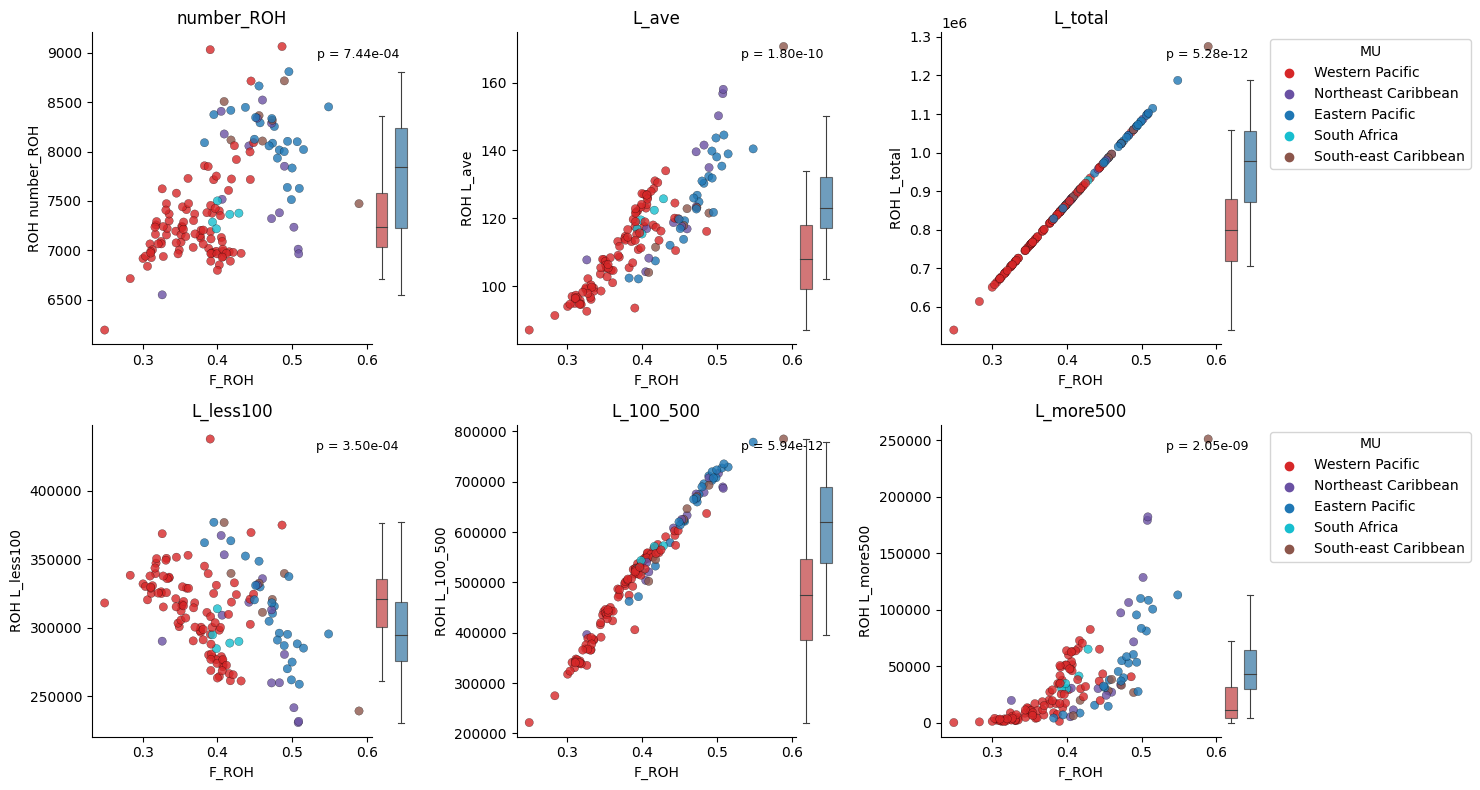

In [39]:
x = 'F_ROH'
values = ['number_ROH', 'L_ave', 'L_total', 'L_less100', 'L_100_500', 'L_more500']

plot_scatter_main(
    df=df_all_roh_include,
    values=values,
    x=x,
    group1='larger_declining',
    group2='small_stable',
    group_col='MU',
    hue_palette=mu_palette_dict,
    pop_palette=population_palette_dict,
    save_path=f'ROH_by_class.{x}.L_S.pdf');

### What are the outlier Northeast Caribbean samples?

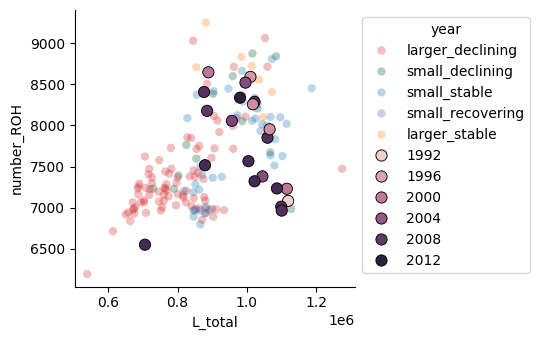

In [75]:
df_temp = df_all_roh_include.copy()
# df_temp = df_temp[df_temp['group'].isin(['larger_declining', 'small_stable', 'small_recovering'])]
df1 = df_temp[df_temp['MU'] == 'Northeast Caribbean']

fig, axes = plt.subplots(figsize=(5.5, 3.5))

sns.scatterplot(ax=axes, data=df_temp, x='L_total', y='number_ROH', 
                hue='group', linewidth=0, alpha=0.3, palette=population_palette_dict)
sns.scatterplot(ax=axes, data=df1, x='L_total', y='number_ROH', edgecolor='k', hue='year', s=65)

sns.move_legend(axes, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
fig.tight_layout()
plt.show()

save_path = 'Northeast_Caribbean.ROHs_N_L_total.by_year.pdf'
# fig.savefig(save_path, bbox_inches='tight')

## 1.7. ROH number 100-500 = f(L_ROH 100-500)

In [24]:
for x, values in [('L_total', ['number_ROH']),
                  ('L_less100', ['N_less100']), 
                  ('L_100_500', ['N_100_500']), 
                  ('L_more500', ['N_more500'])]:
# x = 'L_100_500'
# values = ['N_100_500']

    plot_scatter_grid(
        df=df_all_roh_include,
        values=values,
        x=x,
        group_col='MU',
        hue_palette=mu_palette_dict,
        save_path=f'ROH.{x}.all.pdf');

L_total
['number_ROH']
L_less100
['N_less100']
L_100_500
['N_100_500']
L_more500
['N_more500']


## 1.8. Main groups ROH number 100-500 = f(L_ROH 100-500)

In [31]:
for x, values in [('L_total', ['number_ROH']),
                  ('L_less100', ['N_less100']), 
                  ('L_100_500', ['N_100_500']), 
                  ('L_more500', ['N_more500'])]:

    plot_scatter_main(
        df=df_all_roh_include,
        values=values,
        x=x,
        group1='larger_declining',
        group2='small_stable',
        group_col='MU',
        hue_palette=mu_palette_dict,
        pop_palette=population_palette_dict,
        save_path=f'ROH.{x}.L_S.pdf');

## F_ROH boxplots each MU

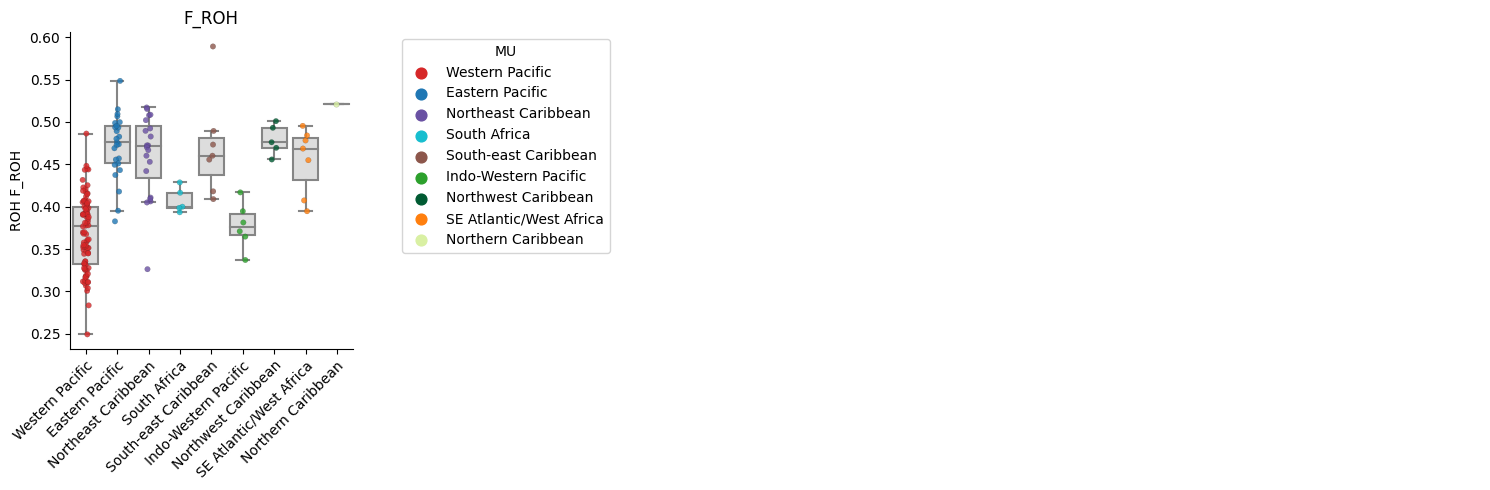

In [66]:
x = 'MU'
values = ['F_ROH']

plot_boxplots(
    df=df_all_roh_include,
    values=values,
    x=x,
    group_col='MU',
    hue_palette=mu_palette_dict,
    save_path=f'F_ROH.boxplot.{x}.all.pdf');

## F_ROH boxplots all groups

In [35]:
x = 'group'
values = ['F_ROH']

plot_boxplots(
    df=df_all_roh_include,
    values=values,
    x=x,
    group_col='MU',
    hue_palette=mu_palette_dict,
    save_path=f'F_ROH.boxplot.{x}.all.pdf');

g1 = 'larger_declining'
g2 = 'small_stable'
x = 'group'
y = 'F_ROH'

# Subset for statistical test
data1 = df_all_roh[df_all_roh[x] == g1][y]
data2 = df_all_roh[df_all_roh[x] == g2][y]
stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
print(pval)

6.650354696762981e-09


# 2. Genetic load = f(ROH)

## 2.1. Number of homs by impact = f(F_ROH)
#### Consider only SNPs (exclude indels)

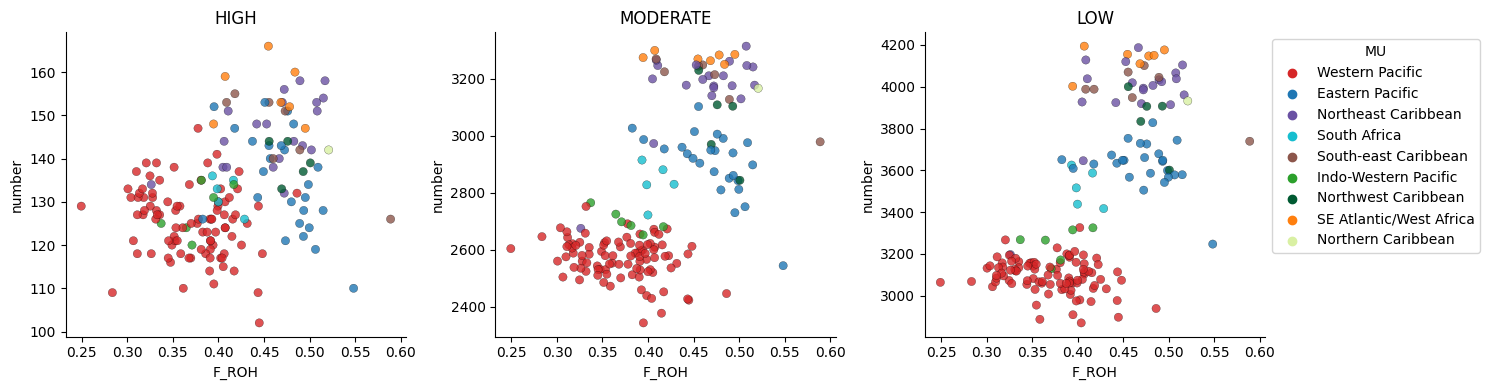

In [93]:
x = 'F_ROH'
impacts = ['HIGH', 'MODERATE', 'LOW']

plot_scatter_grid(
    df=df_roh_merged_include,
    values=impacts,
    x=x,
    group_col='MU',
    hue_palette=mu_palette_dict,
    save_path=f'homs_by_impact.{x}.all.pdf');

## 2.2. Main groups: Number of homs by impact = f(F_ROH)

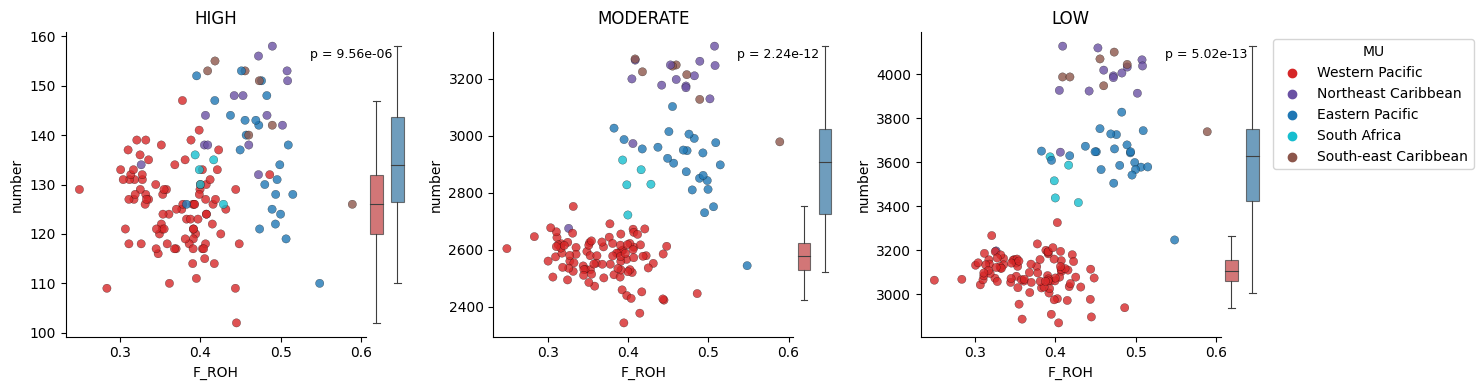

In [102]:
x = 'F_ROH'
impacts = ['HIGH', 'MODERATE', 'LOW']

plot_scatter_main(
    df=df_roh_merged_include,
    values=impacts,
    x=x,
    group1='larger_declining',
    group2='small_stable',
    group_col='MU',
    hue_palette=mu_palette_dict,
    pop_palette=population_palette_dict,
    save_path=f'homs_by_impact.{x}.L_S.pdf');

## 2.3. Main groups: Number of homs by impact = f(ROHs by length class)

In [77]:
values = ['L_less100', 'L_100_500', 'L_more500']
for x in values:
    impacts = ['HIGH', 'MODERATE', 'LOW']

    plot_scatter_main(
        df=df_roh_merged_include,
        values=impacts,
        x=x,
        group1='larger_declining',
        group2='small_stable',
        group_col='MU',
        hue_palette=mu_palette_dict,
        pop_palette=population_palette_dict,
        save_path=f'homs_by_impact.{x}.L_S.pdf');

# 3. Temporal analysis

## 3.1. ROH = f(t) Mexico and Virgin Islands

In [90]:
values = ['L_less100', 'L_100_500', 'L_more500', 'number_ROH', 'F_ROH']
group = 'rookery'
x = 'year'

# temporal_groups = ['Mexico', 'Virgin Islands', 'Indonesia']
temporal_groups = ['Mexico', 'Virgin Islands']
df = df_roh_merged[df_roh_merged[group].isin(temporal_groups)]
df['stage'] = df['stage'].fillna('adult')

plot_scatter_grid(
    df=df.dropna(subset=[x]),
    values=values,
    x=x,
    group_col='MU',
    hue_palette=mu_palette_dict,
    save_path=f'temporal.ROH.{x}.pdf',
    regress=True);

L_less100
                 group   slope_year    p_year  p_C(stage)[T.hatchling]
0  Northeast Caribbean  3566.635619  0.031148                 0.000004
1      Eastern Pacific  -919.575717  0.152108                 0.325773
L_100_500
                 group   slope_year    p_year  p_C(stage)[T.hatchling]
0  Northeast Caribbean -6117.748802  0.141773                 0.366519
1      Eastern Pacific  2858.208243  0.305548                 0.067990
L_more500
                 group   slope_year    p_year  p_C(stage)[T.hatchling]
0  Northeast Caribbean -5554.907105  0.043929                 0.000151
1      Eastern Pacific   709.651140  0.269479                 0.574848
number_ROH
                 group  slope_year    p_year  p_C(stage)[T.hatchling]
0  Northeast Caribbean   30.558958  0.062426             6.201207e-12
1      Eastern Pacific   -3.335626  0.777738             2.512823e-01
F_ROH
                 group  slope_year    p_year  p_C(stage)[T.hatchling]
0  Northeast Caribbean   -0.015116

## 3.2. Genetic load (homs) = f(t) Mexico and Virgin Islands

In [88]:
impacts = ['HIGH', 'MODERATE', 'LOW']
group = 'rookery'
x = 'year'

plot_scatter_grid(
    df=df.dropna(subset=[x]),
    values=impacts,
    x=x,
    group_col='MU',
    hue_palette=mu_palette_dict,
    save_path=f'temporal.homs_by_impact.{x}.pdf',
    regress=True);

HIGH
                 group  slope_year    p_year  p_C(stage)[T.hatchling]
0  Northeast Caribbean    -0.62103  0.065165                 0.838552
1      Eastern Pacific     0.01548  0.928113                 0.543888
MODERATE
                 group  slope_year    p_year  p_C(stage)[T.hatchling]
0  Northeast Caribbean   -0.250363  0.971076                 0.064894
1      Eastern Pacific    4.529791  0.064924                 0.699428
LOW
                 group  slope_year    p_year  p_C(stage)[T.hatchling]
0  Northeast Caribbean   -2.984949  0.761737                 0.079736
1      Eastern Pacific    7.107410  0.005964                 0.488071
